<h2><center>2D Anisotropic Advection for Lighttransport in Vacuum</center></h2>

This notebook explores the numerical solution of the _anisotropic_ $P_1$ Approximation when using a Delta distribution as closure (see survey chapter 2.2.2) in 2-dimensional domain. In vacuum this equation is given as:

$$\nabla\left(D\nabla\phi\right)=-q$$

with

$$D = M\frac{\phi}{\lVert\nabla\phi\rVert}$$.

The diffusion coefficient is anisotropic and therefore a matrix. Here we further assume that the transformation represented by matrix $M$ does not change the length of the transformed vector (this is to keep things simple for now).

The $\phi/\lVert\nabla\phi\rVert$ part of the diffusion coefficient is stored at cell centers and interpolated for its value between voxels. The matrix $M$ is stored at voxel-faces similar to a staggered grid for velocity in fluid simulations. This avoids the problem of having to interpolate anisotropy matrices because they are stored and defined at cell faces already.

Since the diffusion coefficient is a matrix, the discretization of the anisotropic advection equation is quite involved. Please see the notebook "advection_2d_anisotropic_discretization" for all the details.



## Experiment: Single Pointlight in Vacuum with Reflecting Boundary
----------------------------------------------

Testing anisotropic light transport in vacuum is tricky since without participating media, light will always travel in straight lines unhindered. However, anisotropy also shows up when discretizing surfaces which interact with the light. This inspires our first experiment:

We again use a single point light in vacuum. Anisotropy will only be at the interface between inner and border voxels at the right edge of the simulation domain. The purpose is to model a _reflecting_ boundary. The dirichlet boundary condition at boundary voxels is $\phi=0$ which should be correct as no light should pass the reflector. The following image illustrates the setup (gray are boundary cells):

<img src="anisotropic_experiment_1.png" width="256" height="256">

The origins of the red arrows (interface between boundary and inner voxel) define the location at which we want to set the anisotropic diffusion coefficient. The red arrows define the reflection normal.

The anisotropy matrix $M$ for a reflection around normal $\vec{n}$ is given by the householder-transformation: $M = I-2\vec{n}_i\vec{n}_j$. For the right edge interfaces between inner and boundary voxels, we therefore set

$$M=\begin{vmatrix}
-1 & 0\\
0 & 1
\end{vmatrix}$$

In all other locations we set $M=I$.


In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
import numpy as np
import matplotlib.pyplot as plt
from util import *
import solver as solver

In the following cell we will setup the simulation domain and define a function which runs the Gauss-Seidel solver. The emission field, boundary grids and anisotropy matrices are given as arguments and are used during the iteration step which is implemented in c++ and exposed to python via [pybind11](https://github.com/pybind/pybind11).

In [2]:
# setup domain ---
res = 161
size = 1.0
numIterations = 20500
domain = Domain(size, res)


def run_sim( domain, numIterations, Q, M_x, M_y, phi_boundary, D_boundary = None ):
    # setup/reset grids ---
    phi = np.zeros((domain.res, domain.res)) # scalar field for which we want to solve 
    D = np.zeros((domain.res, domain.res)) # diffusion coefficients
    if D_boundary is None:
        D_boundary = np.zeros((domain.res, domain.res)) # D boundary values for dirichlet boundary condition 

    # solve ---
    for step in range(numIterations):
        # call inner loop in c++
        solver.iterate_2d_anisotropic(phi, D, Q, M_x, M_y, phi_boundary, D_boundary, domain.h)
        
    return phi

In the next cell we setup the simulation domain which involves discretization of a pointlight into the emission field Q, initialization of the boundary voxel values to zero and setting up the anisotropy matrices. Since we model a reflecting boundary at the right edge of the simulaion domain, only the last column of voxels will contain a matrix $M$ which is different from the identity matrix.

In [3]:
# SCENE: single pointlight with reflector -----------------------------------------------

# reflection matrix...
def reflection_matrix( n ):
    return np.identity(2) - 2.0*np.outer(n, n)

# initialize emission field ---
Q = np.zeros((domain.res, domain.res))
pointlight1_center_ls = np.array([0.9, 0.5])
pointlight1_center_ws = domain.localToWorld(pointlight1_center_ls)
pointlight1_voxel = domain.voxelToIndex(domain.localToVoxel(pointlight1_center_ls))
Q[ pointlight1_voxel[0], pointlight1_voxel[1] ] = 1.0/(domain.h*domain.h)

# boundary values ---
phi_boundary = np.zeros((domain.res, domain.res)) # phi boundary values for dirichlet boundary condition
D_boundary = np.zeros((domain.res, domain.res)) # D boundary values for dirichlet boundary condition 

# initialize anisotropy matrices ---
# In each voxel we store two matrices. One at the left and another at the bottom cell face (staggered grid).
# M_x holds all matrices on the cell faces in x direction and M_y in y direction
M_x = np.zeros((domain.res+1, domain.res+1, 2, 2))
M_y = np.zeros((domain.res+1, domain.res+1, 2, 2))
for i in range(0, domain.res+1):
    for j in range(0, domain.res+1):
        M_x[i, j] = np.identity(2)
        M_y[i, j] = np.identity(2)

# initialize the rightmost anisotropy matrices to reflection matrices
R = reflection_matrix(np.array([-1.0, 0.0]))
for i in range(domain.res+1):
    M_x[i, domain.res] = R
        
# run simuation ---
phi = run_sim( domain, numIterations, Q, M_x, M_y, phi_boundary, D_boundary)

In the following cell we compute the groundtruth solution for comparison. Note that we slightly shift the boundary to the right in order to avoid singularities from geometry terms. Obviously this introduces an error to our groundtruth reference.

In [5]:
def compute_phi_groundtruth(pWS):
    ''' Compute groundtruth solution for single pointlight with a reflecting surface at the right edge
    of the simulation domain
    '''
    center = pointlight1_center_ws
    power = 1.0

    # one bounce at reflector
    n = np.array([-1.0, 0.0])
    reflection_point = np.array([0.0, 0.0])
    reflection_point[0] = domain.voxelToWorld(np.array([domain.res, domain.res/2.0]))[0]
    reflection_point[0] += 0.025
    reflection_point[1] = pWS[1]*0.5+center[1]*0.5
    reflection_point_ls = domain.worldToLocal(reflection_point)

    if pWS[0] > reflection_point[0]:
        return 0.0

    radiance = power/(2.0*np.pi)

    L0 = radiance
    L0 *= geometry_term_2d(center, None, pWS, None)

    L1 = 0.0
    if reflection_point_ls[1] > 0.0 or reflection_point_ls[1] < 1.0:
        L1 = radiance
        # geometry term center<->reflection_point
        L1 *= geometry_term_2d(center, None, reflection_point, n)
        L1 *= geometry_term_2d(reflection_point, n, pWS, None)

    return L0+L1

phi_groundtruth = domain.rasterize(compute_phi_groundtruth)

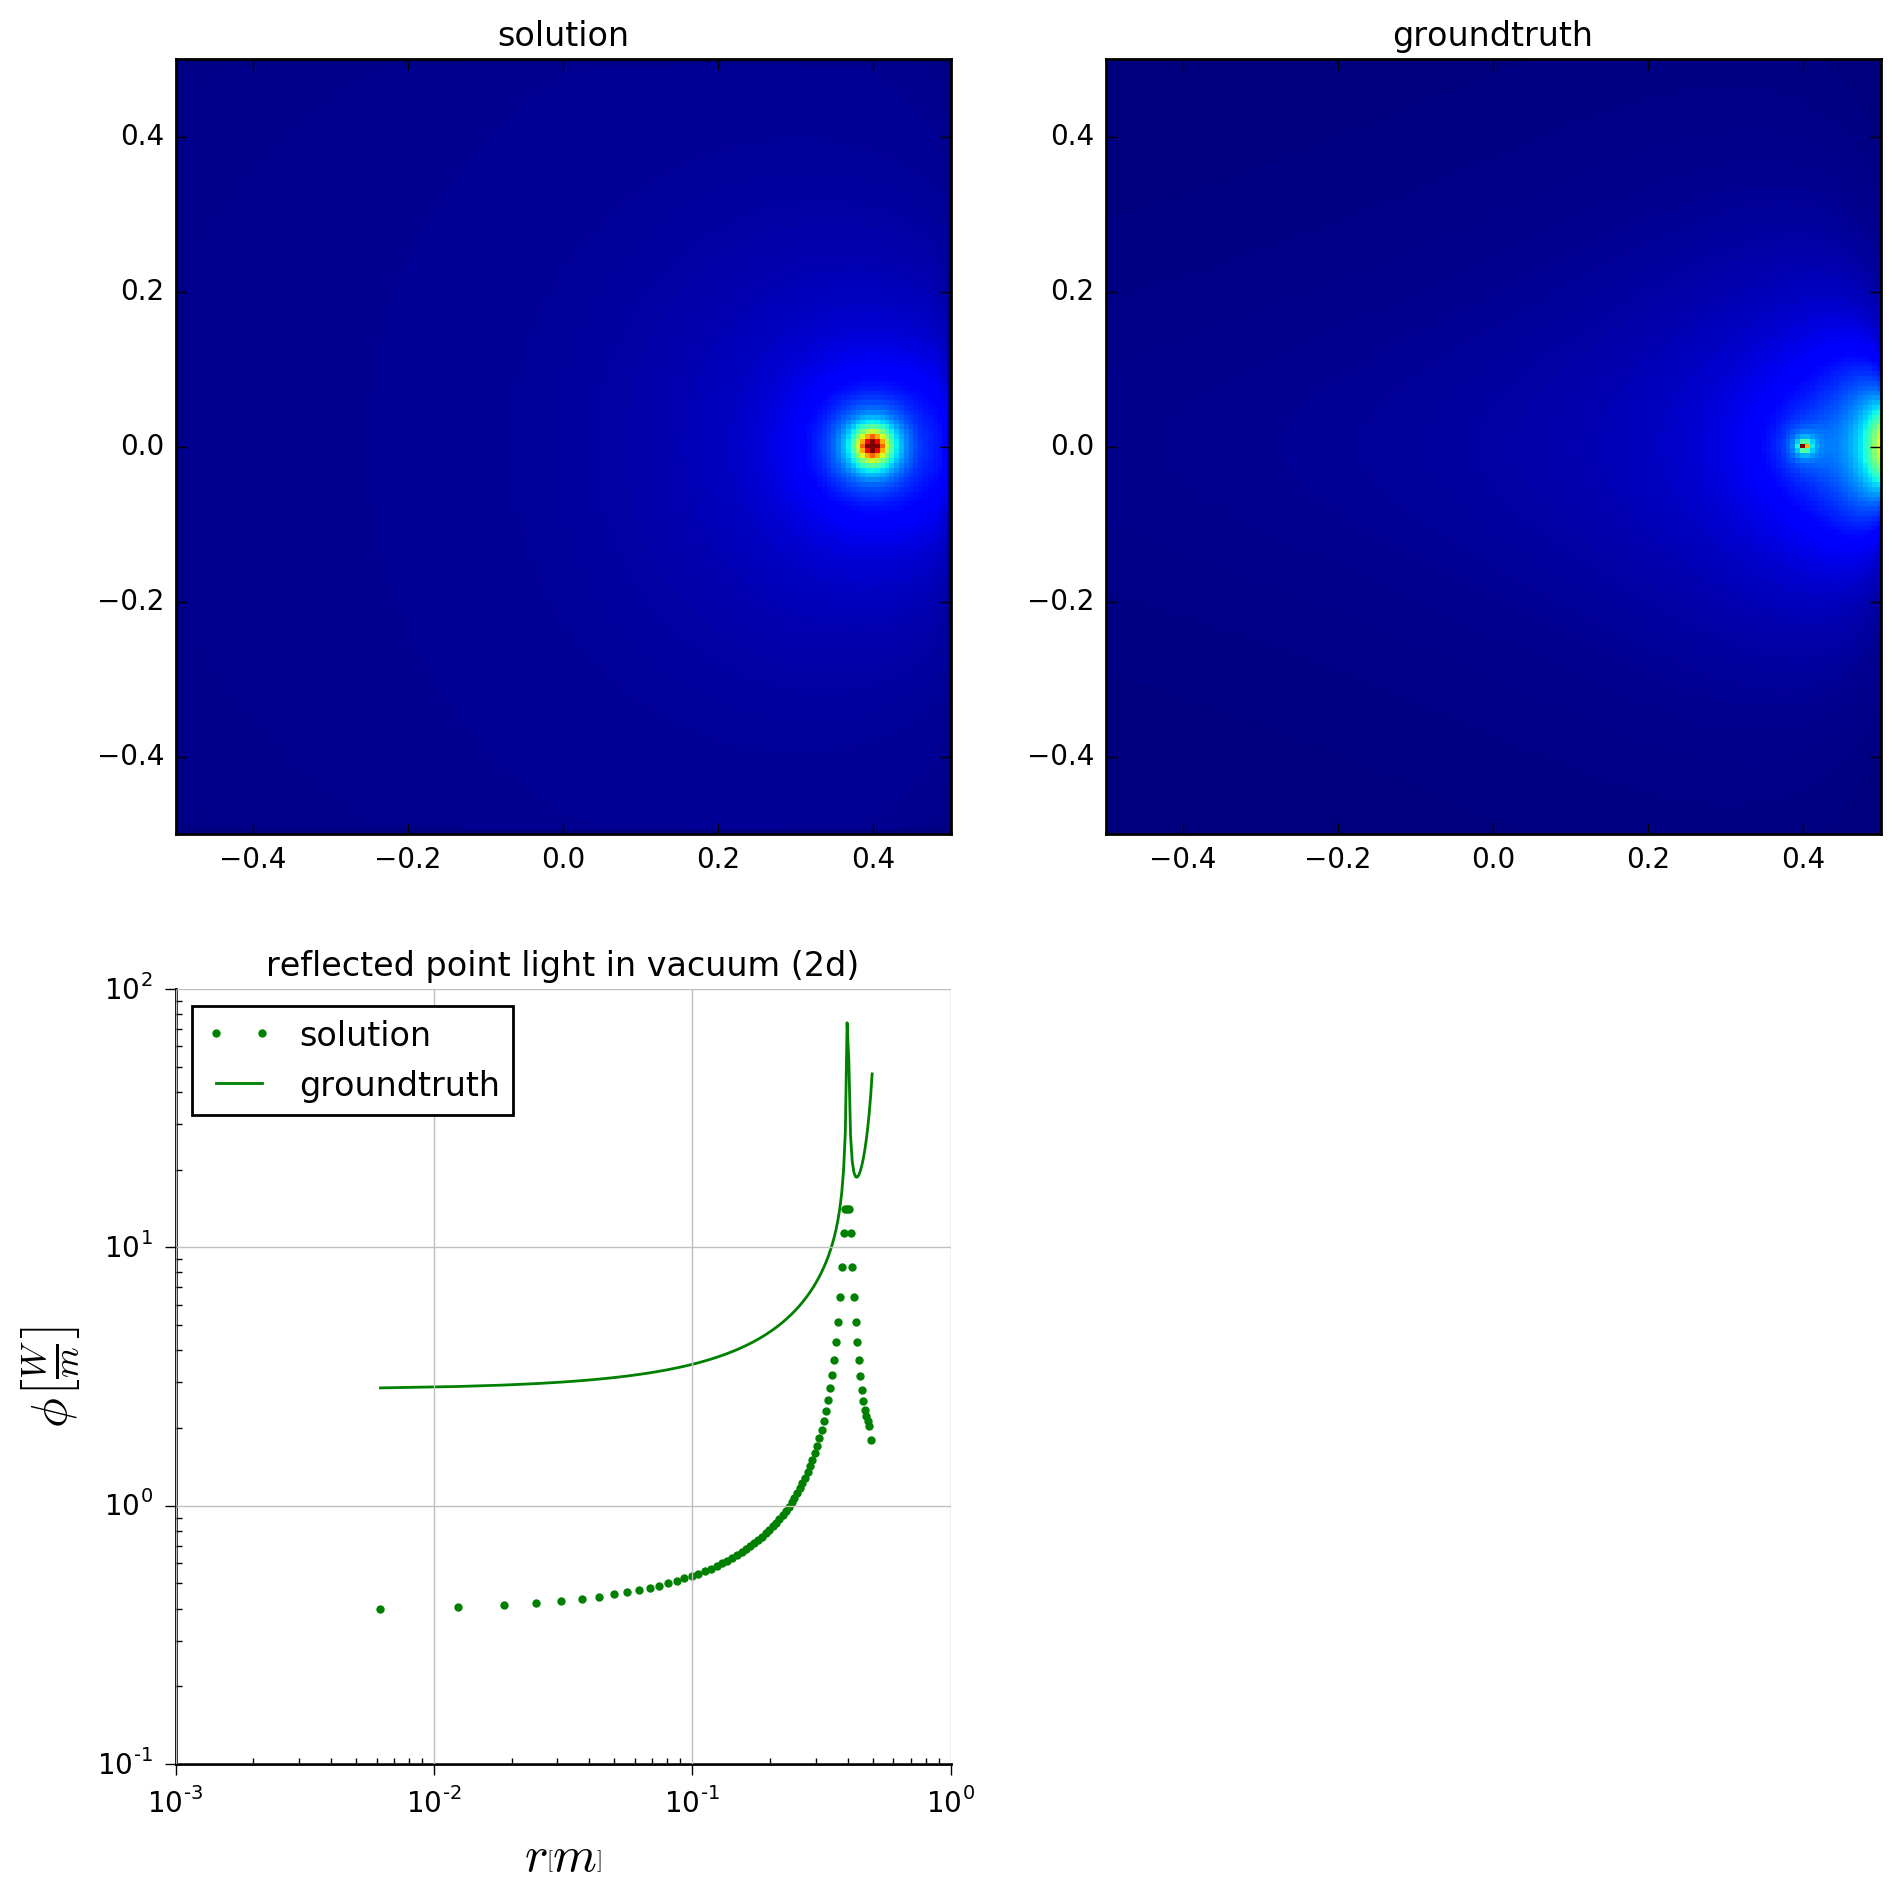

In [6]:
fig = plt.figure(figsize=(11, 11))

plt.subplot(221)
plt.title('solution')
plt.imshow(phi, interpolation="nearest", extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])

plt.subplot(222)
plt.title('groundtruth')
plt.imshow(phi_groundtruth, interpolation="nearest", extent = [domain.bound_min[0], domain.bound_max[0], domain.bound_min[1], domain.bound_max[1]])

plt.subplot(223)
# 1d slice plot
center_voxel = domain.voxelToIndex(domain.worldToVoxel((domain.bound_max+domain.bound_min)/2.0))
domain_x = domain.rasterize( lambda pWS: pWS[0] )

ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='both', direction='out')
ax.get_xaxis().tick_bottom()   # remove unneeded ticks 
ax.get_yaxis().tick_left()
plt.ylim([10.0e-2,10.0e1])
plt.loglog( domain_x[center_voxel[0], center_voxel[1]:], phi[center_voxel[0], center_voxel[1]:], label="solution", color = 'g', linestyle=' ', marker='.', markersize=5 )
plt.loglog( domain_x[center_voxel[0], center_voxel[1]:], phi_groundtruth[center_voxel[0], center_voxel[1]:], label="groundtruth", color = 'g' )
plt.title("reflected point light in vacuum (2d)")
plt.xlabel(r'$r \left[m\right]$', fontsize=18)
plt.ylabel(r'$\phi \left[\frac{W}{m}\right]$', fontsize=18)
plt.grid(True, linestyle='-',color='0.75')
plt.legend(loc='best')


plt.show()

### Discussion

- It appears that anisotropy matrices at the right edge have no impact on the solution of our anisotropic advection equation.
- In this experiment, the matrix $M$ is similar to the identity matrix with the difference that $M_{00} = -1$. This negative sign basically causes a flip of $\nabla\phi$ at the right voxel face (the one which interfaces with the boundary voxel) along the x-direction. This intuitivly means that the flux going out of the voxel to the right will be made to come back in again. This intuitively makes sense for a reflection along a vertical plane. More investigation is required to understand why our model does not work.
- Solving the anisotropic advection equation for the single point light test (without any reflecting boundary) will result in the correct solution (for a single pointlight in vacuum). This implies that the discretization and its implementation is probably correct.

    

---------------

For completeness, we here give the code which is used in the C++ implementation of the inner loop (solver.iterate_2d_anisotropic):
```cpp
void iterate_2d_anisotropic(py::array_t<double> phi_array, // phi grid
	py::array_t<double> D_array, // diffusion coefficient grid
	py::array_t<double> Q_array, // grid of emission values
	py::array_t<double> M_x_array, // grid of 2x2 matrices which represent anisotropy
                                   // on voxel faces perpendicular to x direction
	py::array_t<double> M_y_array, // grid of 2x2 matrices which represent anisotropy
                                   // on voxel faces perpendicular to y direction
	py::array_t<double> phi_boundary_array, // boundary values for phi
	py::array_t<double> D_boundary_array, // boundary values for D
	double h // voxelsize (in x and y)
)
{
	py::buffer_info phi_array_info = phi_array.request();
	py::buffer_info D_array_info = D_array.request();
	py::buffer_info Q_array_info = Q_array.request();
	py::buffer_info M_x_array_info = M_x_array.request();
	py::buffer_info M_y_array_info = M_y_array.request();
	py::buffer_info phi_boundary_array_info = phi_boundary_array.request();
	py::buffer_info D_boundary_array_info = D_boundary_array.request();

	auto phi = static_cast<double *>(phi_array_info.ptr);
	auto D = static_cast<double *>(D_array_info.ptr);
	auto Q = static_cast<double *>(Q_array_info.ptr);
	auto M_x = static_cast<double *>(M_x_array_info.ptr);
	auto M_y = static_cast<double *>(M_y_array_info.ptr);
	auto phi_boundary = static_cast<double *>(phi_boundary_array_info.ptr);
	auto D_boundary = static_cast<double *>(D_boundary_array_info.ptr);

	int res_y = phi_array_info.shape[0];
	int res_x = phi_array_info.shape[1];


	// update boundary conditions ---
	// here we copy over just the ghost cell values from the boundary grids
	for (int i = 0; i < res_y; ++i)
	{
		int idx_0 = index_2d(i, 0, res_x);
		int idx_1 = index_2d(i, res_x - 1, res_x);
		phi[idx_0] = phi_boundary[idx_0];
		phi[idx_1] = phi_boundary[idx_1];
		D[idx_0] = D_boundary[idx_0];
		D[idx_1] = D_boundary[idx_1];
	}
	for (int i = 0; i < res_x; ++i)
	{
		int idx_0 = index_2d(0, i, res_x);
		int idx_1 = index_2d(res_y - 1, i, res_x);
		phi[idx_0] = phi_boundary[idx_0];
		phi[idx_1] = phi_boundary[idx_1];
		D[idx_0] = D_boundary[idx_0];
		D[idx_1] = D_boundary[idx_1];
	}

	// now iterate over all inner cells and update phi and D
	for (int i = 1; i < res_y - 1; ++i)
		for (int j = 1; j < res_x - 1; ++j)
		{
			int idx = index_2d(i, j, res_x);
			int idx_xp = index_2d(i, j + 1, res_x);
			int idx_xm = index_2d(i, j - 1, res_x);
			int idx_yp = index_2d(i - 1, j, res_x);
			int idx_ym = index_2d(i + 1, j, res_x);

			// we will need the diagonal voxels as well
			int idx_xpyp = index_2d(i-1, j+1, res_x);
			int idx_xpym = index_2d(i+1, j+1, res_x);
			int idx_xmyp = index_2d(i-1, j-1, res_x);
			int idx_xmym = index_2d(i+1, j-1, res_x);

			// compute phi gradient at cell center-- -
			V2d grad_phi;
			grad_phi[0] = (phi[idx_xp] - phi[idx_xm]) / (2.0*h);
			grad_phi[1] = (phi[idx_yp] - phi[idx_ym]) / (2.0*h);

			// retrieve M matrices at cell faces ---
			int idx_M_xph = index_M_2d(i, j+1, res_x+1);
			int idx_M_xmh = index_M_2d(i, j, res_x+1);
			int idx_M_yph = index_M_2d(i, j, res_x+1);
			int idx_M_ymh = index_M_2d(i+1, j, res_x+1);
			M22d M_xph;M_xph << M_x[idx_M_xph+0], M_x[idx_M_xph+1], M_x[idx_M_xph+2], M_x[idx_M_xph+3];
			M22d M_xmh;M_xmh << M_x[idx_M_xmh+0], M_x[idx_M_xmh+1], M_x[idx_M_xmh+2], M_x[idx_M_xmh+3];
			M22d M_yph;M_yph << M_y[idx_M_yph+0], M_y[idx_M_yph+1], M_y[idx_M_yph+2], M_y[idx_M_yph+3];
			M22d M_ymh;M_ymh << M_y[idx_M_ymh+0], M_y[idx_M_ymh+1], M_y[idx_M_ymh+2], M_y[idx_M_ymh+3];

			// Compute anisotropic diffusion coefficient matrices at cell faces.
			// Here is where we need to handle the case where D becomes zero.
            // This would cause a division by zero during update of phi.
			// NB: the threshold value for phi has an effect on the accuracy
            // of the solution. It has been hand-picked for the pointsource test.
			double dc = std::max(phi[idx], 0.0004) / std::max(grad_phi.norm(), 1.0e-4);

			// compute diffusion coefficient matrices at cell faces ---
			M22d D_xph = (dc + D[idx_xp])*0.5*M_xph;
			M22d D_xmh = (dc + D[idx_xm])*0.5*M_xmh;
			M22d D_yph = (dc + D[idx_yp])*0.5*M_yph;
			M22d D_ymh = (dc + D[idx_ym])*0.5*M_ymh;

			// update rule for phi ---
			double hinv = 1.0/h;
			double h4inv = 1.0/(4.0*h);

			double numerator = 0.0;
			numerator += h4inv*( D_xmh(0,1) + D_ymh(1,0) )*phi[idx_xmym];
			numerator += hinv*(D_xmh(0,0) - 0.25*D_yph(1,0) + 0.25*D_ymh(1,0))*phi[idx_xm];
			numerator += -h4inv*(D_xmh(0,1)+D_yph(1,0))*phi[idx_xmyp];
			numerator += hinv*(-0.25*D_xph(0,1)+0.25*D_xmh(0,1) + D_ymh(1, 1))*phi[idx_ym];
			numerator += hinv*(0.25*D_xph(0,1)-0.25*D_xmh(0,1)+D_yph(1,1))*phi[idx_yp];
			numerator += -h4inv*(D_xph(0,1) + D_ymh(1,0))*phi[idx_xpym];
			numerator += hinv*(D_xph(0,0)+0.25*D_yph(1,0)-0.25*D_ymh(1,0))*phi[idx_xp];
			numerator += h4inv*(D_xph(0,1) + D_yph(1,0))*phi[idx_xpyp];
			numerator += h*Q[idx];

			double denominator = 0.0;
			denominator += hinv*(D_xph(0,0)+D_xmh(0,0)+D_yph(1,1)+D_ymh(1,1));
						
			phi[idx] = numerator / denominator;
			D[idx] = dc;
		}
}
```